# Τεχνητή Νοημοσύνη και Εφαρμογές στο Διαδίκτυο των Πραγμάτων - 2η Εργασία

Στην εργασία αυτή θα ασχοληθούμε με την ανάπτυξη μοντέλων Συνελικτικών Νευρωνικών ∆ικτύων
(ΣΝ∆) για την κατηγοριοποίηση (classification) εικόνων. Θα χρησιμοποιήσουμε το σύνολο δεδομένωn Food11 Image Classification Dataset, το οποίο περιέχει εικόνες από φαγητά. Στόχος είναι η κατηγοριοποίηση των
εικόνων σε 11 κλάσεις (labels) ανάλογα με το φαγητό που απεικονίζεται. Συγκεκριμένα, το dataset είναι μια
μικρότερη εκδοχή του Food-101 και περιέχει 11000 εικόνες με 11 διαφορετικά είδη φαγητού.

## Φόρτωση Δεδομένων

### 2.1 Βήμα 1 - ∆ημιουργία PyTorch Dataset και Dataloader

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
import torchtext

from PIL import Image
from pathlib import Path

from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt

# My imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from utils import classes, smooth
import numpy as np
import json

Στο παρακάτω code block, φορτώνονται τα δεδομένα και εισάγεται το dictionairy `classes` απο το `utils.py` αρχείο που περιέχει τις κλάσεις των δεδομένων συνοδευόμενες απο ένα σχετικό μοναδικό αριθμό (ID) το οποίο χρησιμεύει για τη δημιουργία των κλάσεων των νευρωνικών δικτύων

In [2]:
# Φορτώστε τα δεδομένα από τα CSV αρχεία χρησιμοποιώντας το pandas
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

print("classes:", json.dumps(classes, indent=4))

classes: {
    "apple_pie": 0,
    "cheesecake": 1,
    "chicken_curry": 2,
    "french_fries": 3,
    "fried_rice": 4,
    "hamburger": 5,
    "hot_dog": 6,
    "ice_cream": 7,
    "omelette": 8,
    "pizza": 9,
    "sushi": 10
}


Στον παραπάνω κώδικα, η κλάση `FoodDataset` δέχεται ένα DataFrame ως είσοδο κατά την αρχικοποίηση και μπορεί να εφαρμόσει μετασχηματισμούς στις εικόνες. Η μέθοδος `__getitem__` επιστρέφει την εικόνα και την ετικέτα της για ένα συγκεκριμένο δείγμα.

In [3]:
class FoodDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.class_to_idx = classes

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]  # contains file paths
        image = Image.open(img_name)
        label = self.dataframe.iloc[idx, 1]  # contains labels
        
        label = self.class_to_idx[label]
        
        if self.transform:
            image = self.transform(image)

        return image, label

Αυτός ο κώδικας θα δημιουργήσει τα `train_loader` και `val_loader` που θα χρησιμοποιηθούν για την εκπαίδευση και την επικύρωση του μοντέλου αντίστοιχα.

In [27]:
train_set, val_set = train_test_split(train_data, test_size=0.2, random_state=42)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = FoodDataset(train_set, transform=transform)
val_dataset = FoodDataset(val_set, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

### 2.2 Βήμα 2 - ∆οκιμές

Αυτός ο κώδικας προβάλει μία τυχαία επιλεγμένη εικόνα από το dataset, μαζί με την αντίστοιχη ετικέτα της προκειμένου να ελεγχθεί η ορθή φόρτωση των δεδομένων

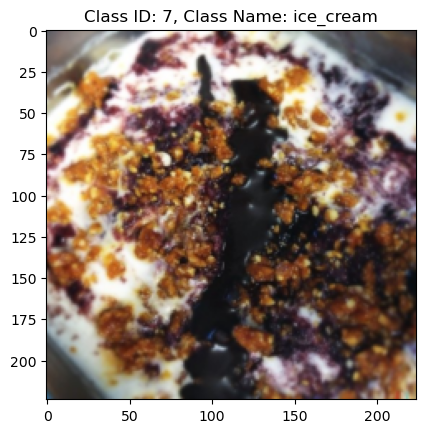

In [34]:
# Λειτουργία για να εμφανίζουμε τις εικόνες μαζί με το όνομα της κλάσης
def imshow_with_class(img, class_id, classes):
    class_name = list(classes.keys())[list(classes.values()).index(class_id)]
    plt.imshow(img.permute(1, 2, 0))  # Μετατροπή του tensor σε μορφή εικόνας (H, W, C)
    plt.title(f'Class ID: {class_id}, Class Name: {class_name}')
    plt.show()

# Λήψη ενός batch από τα δεδομένα εκπαίδευσης
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Εμφάνιση του πρώτου δείγματος από το batch
class_id = labels[0].item()
imshow_with_class(images[0], class_id, classes)

### 2.3 Βήμα 3 - Ορισμός Training Loop

Η συνάρτηση `train_model` εκπαιδεύει το μοντέλο για έναν συγκεκριμένο αριθμό εποχών, χρησιμοποιώντας έναν επιλεγμένο αλγόριθμο βελτιστοποίησης και ένα κριτήριο απώλειας. Κατά τη διάρκεια κάθε εποχής, υπολογίζονται οι μετρικές εκπαίδευσης και επικύρωσης και αποθηκεύονται για να ελεγχθεί η απόδοση του μοντέλου. 

Η συνάρτηση `evaluate_model` χρησιμοποιείται για τον έλεγχο της απόδοσης του μοντέλου σε ένα σύνολο δεδομένων (είτε στο σύνολο επικύρωσης είτε στο σύνολο δοκιμής). Αυτή η συνάρτηση υπολογίζει την απώλεια και την ακρίβεια του μοντέλου.

In [6]:
# Ορίζουμε τη συσκευή εκτέλεσης (device) που θα χρησιμοποιήσουμε
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device to be used during training: {device}")

# Ορίζουμε τη συνάρτηση εκπαίδευσης
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30):
    # Early stopping parameters
    patience=5
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    
    # Μετακινούμε το μοντέλο στη συσκευή εκτέλεσης
    model = model.to(device)

    # For training metrics
    train_loss_hist = []
    train_acc_hist = []
    val_loss_hist = []
    val_acc_hist = []

    metrics = {}
    
    # Ξεκινάμε την εκπαίδευση
    for epoch in range(num_epochs):
        # Θέτουμε το μοντέλο σε κατάσταση εκπαίδευσης
        model.train()
        
        # Αρχικοποίηση των μετρικών
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Εκπαίδευση του μοντέλου σε κάθε batch
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
            images, labels = images.to(device), labels.to(device)
            
            # Μηδενίζουμε τις καταχωρήσεις των gradients
            optimizer.zero_grad()
            
            # Προϋπολογισμός των προβλέψεων
            outputs = model(images)
            
            # Υπολογισμός της απώλειας
            loss = criterion(outputs, labels)
            
            # Αντίστροφη διάδοση του σφάλματος και ενημέρωση των βαρών
            loss.backward()
            optimizer.step()
            
            # Καταγραφή της απώλειας
            running_loss += loss.item()
            
            # Υπολογισμός της ακρίβειας
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # Εκτύπωση της απώλειας και της ακρίβειας στο σύνολο εκπαίδευσης
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        
        # Αξιολόγηση του μοντέλου στο σύνολο επικύρωσης
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        train_loss_hist.append(train_loss)
        train_acc_hist.append(train_accuracy)
        val_loss_hist.append(val_loss)
        val_acc_hist.append(val_accuracy)
        
        # Έλεγχος για πρόωρο τερματισμό αν δεν υπάρχει βελτίωση στο σύνολο επικύρωσης
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement == patience:
                print(f"No improvement for {patience} epochs. Early stopping...")
                break
        
        # Save metrics
        metrics['train_loss'] = train_loss_hist
        metrics['train_acc'] = train_acc_hist
        metrics['val_loss'] = val_loss_hist
        metrics['val_acc'] = val_acc_hist
        
    print("Training completed.")
    
    return metrics

# Ορίζουμε τη συνάρτηση αξιολόγησης
def evaluate_model(model, data_loader, criterion):
    # Θέτουμε το μοντέλο σε κατάσταση αξιολόγησης
    model.eval()
    
    # Αρχικοποίηση των μετρικών
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Αξιολόγηση του μοντέλου στα δεδομένα
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Υπολογισμός των προβλέψεων
            outputs = model(images)
            
            # Υπολογισμός της απώλειας
            loss = criterion(outputs, labels)
            
            # Καταγραφή της απώλειας
            running_loss += loss.item()
            
            # Υπολογισμός της ακρίβειας
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Υπολογισμός της απώλειας και της ακρίβειας
    loss = running_loss / len(data_loader)
    accuracy = correct / total
    
    return loss, accuracy

Device to be used during training: cuda


Αυτή η συνάρτηση αξιολογεί το μοντέλο στο δεδομένο data_loader, υπολογίζοντας την απώλεια και την ακρίβεια. Επιστρέφει επίσης την απώλεια και την ακρίβεια για μελλοντική αναφορά.

Αυτές οι συναρτήσεις μπορούν να χρησιμοποιηθούν για την εκπαίδευση και την αξιολόγηση ενός μοντέλου στο PyTorch.

### **1. Ποιος ο λόγος που έχουμε κρατήσει ένα κομμάτι του συνόλου εκπαίδευσης ως σύνολο επικύρωσης; ∆ε θα ήταν πιο λογικό να έχουμε περισσότερα δεδομένα για να εκπαιδεύσουμε τα μοντέλα μας; Εξηγήστε.**


Η κράτηση ενός κομματιού του συνόλου εκπαίδευσης ως σύνολο επικύρωσης έχει ως στόχο την αξιολόγηση της γενικευτικής ικανότητας του μοντέλου. Το σύνολο επικύρωσης χρησιμεύει για την επίβλεψη της απόδοσης του μοντέλου κατά τη διάρκεια της εκπαίδευσης και της προσαρμογής των υπερπαραμέτρων του μοντέλου (όπως ο ρυθμός μάθησης) ώστε να αποφευχθεί το overfitting. Η χρήση ενός ξεχωριστού συνόλου επικύρωσης βοηθά στην αποφυγή του overfitting και στη βελτίωση της γενίκευσης του μοντέλου. Αν εκπαιδεύαμε το μοντέλο με όλα τα δεδομένα, θα υπήρχε ο κίνδυνος να είναι πολύ καλό στο σύνολο εκπαίδευσης αλλά να μην γενικεύει καλά σε νέα δεδομένα.

### **2. Τί πρόβλημα καλούμαστε να λύσουμε στο συγκεκριμένο dataset; Ποια είναι η κατάλληλη συνάρτηση απώλειας για να εκπαιδεύσουμε ένα μοντέλο για ένα τέτοιου είδους προβλήματος;**

Το πρόβλημα που καλούμαστε να λύσουμε στο συγκεκριμένο dataset είναι η αναγνώριση της κατηγορίας των τροφίμων από εικόνες. Αυτό είναι ένα πρόβλημα ταξινόμησης πολλαπλών κατηγοριών, όπου κάθε εικόνα μπορεί να ανήκει σε μία από πολλές διαφορετικές κατηγορίες τροφίμων. Για την εκπαίδευση ενός μοντέλου για ένα τέτοιο πρόβλημα, μια κατάλληλη συνάρτηση απώλειας είναι η κατηγορική απώλεια (categorical cross-entropy), η οποία είναι κατάλληλη για την αναγνώριση πολλαπλών κατηγοριών.

# Εκπαίδευση Συνελικτικών ∆ικτύων

Σε αυτό το βήμα εξετάζονται διάφορες αρχιτεκτονικές ΣΝΔ που να είναι ικάνα να λύσουν το πρόβλημα της κατηγοροποίησης των εικόνων

## 3.1 Εκπαίδευση

Ξεκινάμε με μια αρχιτεντονική μικρού δικτύου. Αυτό το δίκτυο έχει τα παρακάτω χαρακτηριστικά:


• Αλγόριθμο βελτιστοποίησης Adam με ρυθμό εκμάθησης 10<sup>4</sup>

• Εκτύπωση της απώλειας (loss), ορθότητας (accuracy) των υποσυνόλων εκπαίδευσης και επικύρωσης

• 30 εποχές μέγιστη διάρκεια εκπαίδευσης

• Πρόωρο τερματισμό της εκπαίδευσης (Early Stopping) αν δεν παρουσιαστεί μείωση της απώλειας στο
σύνολο επικύρωσης για 5 συνεχείς εποχές

In [7]:
class SmallNet(nn.Module):
    def __init__(self, num_classes=11):
        super(SmallNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc = nn.Linear(128 * 28 * 28, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        
        x = x.view(x.size(0), -1)  # Flatten
        
        x = self.fc(x)
        return x

smallnet_model = SmallNet()

### Εκπαίδευση Συνελικτικών ∆ικτύων

In [37]:
# Δρημιουργία αντικειμένου ΣΝΔ
smallnet_model = SmallNet()

# Ορίζουμε τον αλγόριθμο βελτιστοποίησης, το κριτήριο και τον βελτιστοποιητή
optimizer = optim.Adam(smallnet_model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

# Εκπαιδεύουμε το μοντέλο
smallnet_model_metrics = train_model(smallnet_model, train_loader, val_loader, criterion, optimizer)

Epoch 1/30: 100%|██████████| 124/124 [00:18<00:00,  6.64it/s]


Train Loss: 2.2955, Train Accuracy: 0.1788
Validation Loss: 2.1679, Validation Accuracy: 0.2576


Epoch 2/30: 100%|██████████| 124/124 [00:18<00:00,  6.65it/s]


Train Loss: 2.1007, Train Accuracy: 0.2746
Validation Loss: 2.0948, Validation Accuracy: 0.2798


Epoch 3/30: 100%|██████████| 124/124 [00:18<00:00,  6.66it/s]


Train Loss: 1.9830, Train Accuracy: 0.3279
Validation Loss: 2.0148, Validation Accuracy: 0.3152


Epoch 4/30: 100%|██████████| 124/124 [00:18<00:00,  6.69it/s]


Train Loss: 1.8926, Train Accuracy: 0.3681
Validation Loss: 1.9706, Validation Accuracy: 0.3323


Epoch 5/30: 100%|██████████| 124/124 [00:18<00:00,  6.66it/s]


Train Loss: 1.8062, Train Accuracy: 0.4052
Validation Loss: 1.9265, Validation Accuracy: 0.3465


Epoch 6/30: 100%|██████████| 124/124 [00:18<00:00,  6.69it/s]


Train Loss: 1.7129, Train Accuracy: 0.4437
Validation Loss: 1.9036, Validation Accuracy: 0.3657


Epoch 7/30: 100%|██████████| 124/124 [00:18<00:00,  6.59it/s]


Train Loss: 1.6149, Train Accuracy: 0.4718
Validation Loss: 1.9352, Validation Accuracy: 0.3525


Epoch 8/30: 100%|██████████| 124/124 [00:18<00:00,  6.69it/s]


Train Loss: 1.5146, Train Accuracy: 0.5092
Validation Loss: 1.9492, Validation Accuracy: 0.3525


Epoch 9/30: 100%|██████████| 124/124 [00:18<00:00,  6.63it/s]


Train Loss: 1.3857, Train Accuracy: 0.5545
Validation Loss: 1.9166, Validation Accuracy: 0.3753


Epoch 10/30: 100%|██████████| 124/124 [00:18<00:00,  6.67it/s]


Train Loss: 1.2700, Train Accuracy: 0.5955
Validation Loss: 1.9588, Validation Accuracy: 0.3732


Epoch 11/30: 100%|██████████| 124/124 [00:18<00:00,  6.74it/s]


Train Loss: 1.1516, Train Accuracy: 0.6364
Validation Loss: 1.9830, Validation Accuracy: 0.3747
No improvement for 5 epochs. Early stopping...
Training completed.


### Αξιολόγηση

In [9]:
# Helper function with Exponential Weighted Moving Average implementation for smoothing the lines
def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return smoothed

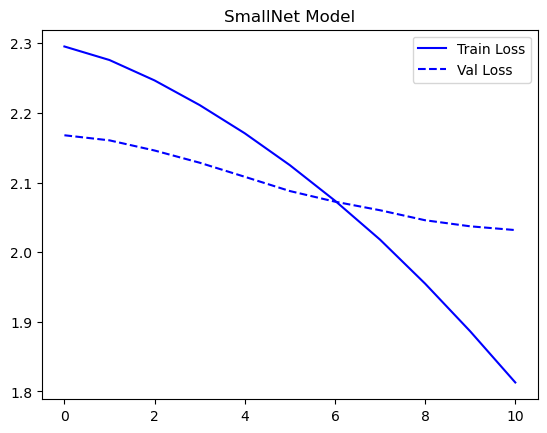

In [48]:
plt.plot(smooth(smallnet_model_metrics['train_loss'], 0.9), 'b')
plt.plot(smooth(smallnet_model_metrics['val_loss'], 0.9), 'b--')
plt.title('SmallNet Model')
plt.legend(['Train Loss', 'Val Loss'])

Η απώλεια εκπαίδευσης γενικά μειώνεται με την πάροδο του χρόνου, γεγονός που υποδηλώνει ότι το μοντέλο μαθαίνει και βελτιώνει την απόδοσή του στα δεδομένα εκπαίδευσης. Η απώλεια επικύρωσης μειώνεται επίσης, γεγονός που υποδηλώνει ότι το μοντέλο γενικεύει καλά και δεν προσαρμόζεται υπερβολικά στα δεδομένα εκπαίδευσης.

 ## Συνελικτικό δίκτυο μεγάλου βάθους

Δημιουργείται ένα νεο ΣΝΔ μεγαλύτερου βάθους με τα εξής χαρακτηριστικά:

- Τρία συνελικτικά επίπεδα ακολουθούμενα από επίπεδα συγκέντρωσης (Max pooling) 
- Ένα πλήρως συνδεδεμένο επίπεδο στο τέλος.

In [11]:
class BigNet(nn.Module):
    def __init__(self, num_classes=11):
        super(BigNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, 128 * 28 * 28)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [12]:
# Create an instance of the BigNet model
bignet_model = BigNet()

# Ορίζουμε τον αλγόριθμο βελτιστοποίησης, το κριτήριο και τον βελτιστοποιητή
optimizer = optim.Adam(bignet_model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

# Εκπαιδεύουμε το μοντέλο
bignet_model_metrics = train_model(bignet_model, train_loader, val_loader, criterion, optimizer)

Epoch 1/30: 100%|██████████| 124/124 [00:18<00:00,  6.56it/s]


Train Loss: 2.3025, Train Accuracy: 0.1663
Validation Loss: 2.2193, Validation Accuracy: 0.1859


Epoch 2/30: 100%|██████████| 124/124 [00:19<00:00,  6.46it/s]


Train Loss: 2.1178, Train Accuracy: 0.2525
Validation Loss: 2.1065, Validation Accuracy: 0.2652


Epoch 3/30: 100%|██████████| 124/124 [00:18<00:00,  6.58it/s]


Train Loss: 1.9988, Train Accuracy: 0.3110
Validation Loss: 2.0177, Validation Accuracy: 0.2985


Epoch 4/30: 100%|██████████| 124/124 [00:19<00:00,  6.49it/s]


Train Loss: 1.8953, Train Accuracy: 0.3524
Validation Loss: 1.9541, Validation Accuracy: 0.3247


Epoch 5/30: 100%|██████████| 124/124 [00:19<00:00,  6.42it/s]


Train Loss: 1.7938, Train Accuracy: 0.3960
Validation Loss: 1.9654, Validation Accuracy: 0.3354


Epoch 6/30: 100%|██████████| 124/124 [00:18<00:00,  6.61it/s]


Train Loss: 1.6935, Train Accuracy: 0.4313
Validation Loss: 1.9462, Validation Accuracy: 0.3455


Epoch 7/30: 100%|██████████| 124/124 [00:19<00:00,  6.35it/s]


Train Loss: 1.6051, Train Accuracy: 0.4634
Validation Loss: 1.8832, Validation Accuracy: 0.3626


Epoch 8/30: 100%|██████████| 124/124 [00:19<00:00,  6.45it/s]


Train Loss: 1.4774, Train Accuracy: 0.5092
Validation Loss: 1.9239, Validation Accuracy: 0.3520


Epoch 9/30: 100%|██████████| 124/124 [00:19<00:00,  6.40it/s]


Train Loss: 1.3686, Train Accuracy: 0.5505
Validation Loss: 1.9164, Validation Accuracy: 0.3773


Epoch 10/30: 100%|██████████| 124/124 [00:19<00:00,  6.36it/s]


Train Loss: 1.2150, Train Accuracy: 0.6077
Validation Loss: 1.9551, Validation Accuracy: 0.3742


Epoch 11/30: 100%|██████████| 124/124 [00:19<00:00,  6.37it/s]


Train Loss: 1.0772, Train Accuracy: 0.6529
Validation Loss: 2.0003, Validation Accuracy: 0.3652


Epoch 12/30: 100%|██████████| 124/124 [00:18<00:00,  6.63it/s]


Train Loss: 0.9345, Train Accuracy: 0.7013
Validation Loss: 2.0858, Validation Accuracy: 0.3556
No improvement for 5 epochs. Early stopping...
Training completed.


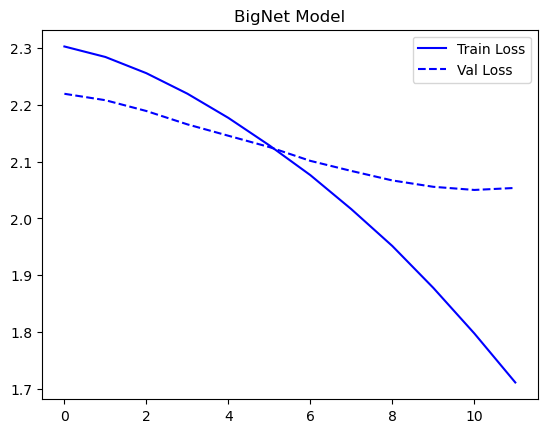

In [13]:
# Plot Train and Val losses
plt.plot(smooth(bignet_model_metrics['train_loss'], 0.9), 'b')
plt.plot(smooth(bignet_model_metrics['val_loss'], 0.9), 'b--')
plt.title('BigNet Model')
plt.legend(['Train Loss', 'Val Loss'])

Παρατηρείται πως η επίδοση του μεγαλύτερου μοντέλου οδηγεί σε overfitting. Αυτό δίνει τη δυνατότητα στο δίκτυο να μάθει πολύπλοκα μοτίβα και ακόμα και θόρυβο στα δεδομένα εκπαίδευσης, κάτι που μπορεί να μη γενικεύει καλά σε νέα δεδομένα. 

Ο μεγάλος αριθμός επιπέδων και νευρώνων στο `BigNet` μοντέλο πιθανόν λόγω των περισσοτέρων παραμέτρους που έχει δεν είναι ικανό να γενικεύσει. Ιδίως στη περίπτωση που το μοντέλο δεν έχει κατάλληλη τεχνική ομαλοποίησης και ελέγχου χωρητικότητας.

Μια τεχνική ομαλοποίησης που μπορεί να χρησιμοποιηθεί είναι η απόσυρση (dropout). Η απόσυρση μπορεί να εφαρμοστεί μεταξύ των πλήρως συνδεδεμένων επιπέδων για να αποτρέψει την υπερ-προσαρμογή. Επιπλέον, μπορεί να χρησιμοποιηθεί η κανονικοποίηση βάρους (weight regularization), όπως η L2 κανονικοποίηση, για να ελέγξει το μέγεθος των βαρών του μοντέλου και να αποτρέψει την υπερ-προσαρμογή.

Έτσι, μπορούμε να δοκιμάσουμε τεχικές ομαλοποίησης σε αυτό για να δούμε εαν αυτές θα επιφέρουν αλλαγές στην επίδοση του ξεκινώντας απο το περιορισμό των τιμών που μπορούν να πάρουν τα βάρη του δικτύου. Αυτό ρυθμίζεται μεσα στον `optimizer` ως παράμετρος της σχετικής συνάρτησης (`weight_decay`).

In [14]:
# Create an instance of the BigNet model
bignet_model_v2 = BigNet()

# Ορίζουμε τον αλγόριθμο βελτιστοποίησης, το κριτήριο και τον βελτιστοποιητή
optimizer = optim.Adam(bignet_model_v2.parameters(), lr=0.0001, weight_decay=0.0005)
criterion = nn.CrossEntropyLoss()

# Εκπαιδεύουμε το μοντέλο
bignet_model_v2_metrics = train_model(bignet_model_v2, train_loader, val_loader, criterion, optimizer)

Epoch 1/30: 100%|██████████| 124/124 [00:19<00:00,  6.51it/s]


Train Loss: 2.3136, Train Accuracy: 0.1561
Validation Loss: 2.2365, Validation Accuracy: 0.1843


Epoch 2/30: 100%|██████████| 124/124 [00:19<00:00,  6.41it/s]


Train Loss: 2.1699, Train Accuracy: 0.2405
Validation Loss: 2.1452, Validation Accuracy: 0.2611


Epoch 3/30: 100%|██████████| 124/124 [00:18<00:00,  6.62it/s]


Train Loss: 2.0532, Train Accuracy: 0.2914
Validation Loss: 2.0681, Validation Accuracy: 0.2879


Epoch 4/30: 100%|██████████| 124/124 [00:18<00:00,  6.54it/s]


Train Loss: 1.9614, Train Accuracy: 0.3316
Validation Loss: 1.9931, Validation Accuracy: 0.3232


Epoch 5/30: 100%|██████████| 124/124 [00:18<00:00,  6.66it/s]


Train Loss: 1.8597, Train Accuracy: 0.3734
Validation Loss: 1.9902, Validation Accuracy: 0.3116


Epoch 6/30: 100%|██████████| 124/124 [00:18<00:00,  6.57it/s]


Train Loss: 1.7822, Train Accuracy: 0.3939
Validation Loss: 1.9840, Validation Accuracy: 0.3131


Epoch 7/30: 100%|██████████| 124/124 [00:19<00:00,  6.49it/s]


Train Loss: 1.7049, Train Accuracy: 0.4245
Validation Loss: 1.9363, Validation Accuracy: 0.3399


Epoch 8/30: 100%|██████████| 124/124 [00:18<00:00,  6.53it/s]


Train Loss: 1.6195, Train Accuracy: 0.4540
Validation Loss: 1.9068, Validation Accuracy: 0.3540


Epoch 9/30: 100%|██████████| 124/124 [00:19<00:00,  6.36it/s]


Train Loss: 1.5189, Train Accuracy: 0.4958
Validation Loss: 1.9468, Validation Accuracy: 0.3505


Epoch 10/30: 100%|██████████| 124/124 [00:19<00:00,  6.42it/s]


Train Loss: 1.4310, Train Accuracy: 0.5232
Validation Loss: 1.9181, Validation Accuracy: 0.3652


Epoch 11/30: 100%|██████████| 124/124 [00:19<00:00,  6.43it/s]


Train Loss: 1.3238, Train Accuracy: 0.5664
Validation Loss: 2.0300, Validation Accuracy: 0.3303


Epoch 12/30: 100%|██████████| 124/124 [00:18<00:00,  6.55it/s]


Train Loss: 1.1998, Train Accuracy: 0.6109
Validation Loss: 2.0349, Validation Accuracy: 0.3596


Epoch 13/30: 100%|██████████| 124/124 [00:19<00:00,  6.48it/s]


Train Loss: 1.0586, Train Accuracy: 0.6587
Validation Loss: 2.0850, Validation Accuracy: 0.3621
No improvement for 5 epochs. Early stopping...
Training completed.


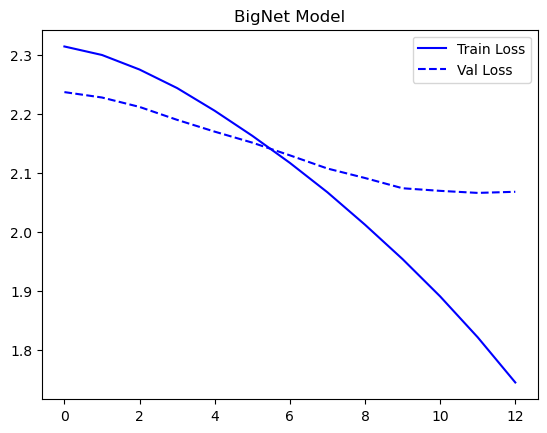

In [15]:
# Plot Train and Val losses
plt.plot(smooth(bignet_model_v2_metrics['train_loss'], 0.9), 'b')
plt.plot(smooth(bignet_model_v2_metrics['val_loss'], 0.9), 'b--')
plt.title('BigNet Model')
plt.legend(['Train Loss', 'Val Loss'])

Τα αποτελέσματα δε προσδίδουν κάποια εμφανή αλλαγή. Έτσι, επιστρατεύεται η τεχνική ομαλοποίησης "Dropout" η οποία αποκόπτει τυχαία μερίδα νευρώνων με κάποια πιθανότητα p από κάθε επίπεδο του δικτύου κατά τη διάρκεια κάθε εποχής εκπαίδευσης.

Αυτό έχει ως αποτέλεσμα το δίκτυο να μην μπορεί να βασιστεί υπερβολικά σε συγκεκριμένους νευρώνες και να αναπτύσσει πιο γενικευμένα χαρακτηριστικά.

Προστίθεται έτσι ενα επίπεδο Dropout μετά απο επίπδα συνέλιξης με πιθανότητα 0.5

In [16]:
import torch.nn as nn

class BigNetDropout(nn.Module):
    def __init__(self, num_classes=11):
        super(BigNetDropout, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.5)  # Ορίζουμε την πιθανότητα dropout (εδώ 0.5)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout(x)  # Προσθήκη Dropout μετά το πρώτο max pooling layer
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout(x)  # Προσθήκη Dropout μετά το δεύτερο max pooling layer
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout(x)  # Προσθήκη Dropout μετά το τρίτο max pooling layer
        x = x.view(-1, 128 * 28 * 28)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)  # Προσθήκη Dropout μετά το πρώτο fully connected layer
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)  # Προσθήκη Dropout μετά το δεύτερο fully connected layer
        x = self.fc3(x)
        return x


In [17]:
# Dropout Net
bignet_model_v3 = BigNetDropout()

# Ορίζουμε τον αλγόριθμο βελτιστοποίησης, το κριτήριο και τον βελτιστοποιητή
optimizer = optim.Adam(bignet_model_v3.parameters(), lr=0.0001, weight_decay=0.0005)
criterion = nn.CrossEntropyLoss()

# Εκπαιδεύουμε το μοντέλο
bignet_model_v3_metrics = train_model(bignet_model_v3, train_loader, val_loader, criterion, optimizer)

Epoch 1/30: 100%|██████████| 124/124 [00:18<00:00,  6.57it/s]


Train Loss: 2.4061, Train Accuracy: 0.0923
Validation Loss: 2.3967, Validation Accuracy: 0.1167


Epoch 2/30: 100%|██████████| 124/124 [00:18<00:00,  6.68it/s]


Train Loss: 2.3665, Train Accuracy: 0.1265
Validation Loss: 2.3424, Validation Accuracy: 0.1455


Epoch 3/30: 100%|██████████| 124/124 [00:19<00:00,  6.45it/s]


Train Loss: 2.3088, Train Accuracy: 0.1652
Validation Loss: 2.3268, Validation Accuracy: 0.1914


Epoch 4/30: 100%|██████████| 124/124 [00:18<00:00,  6.67it/s]


Train Loss: 2.2770, Train Accuracy: 0.1802
Validation Loss: 2.2912, Validation Accuracy: 0.2086


Epoch 5/30: 100%|██████████| 124/124 [00:19<00:00,  6.47it/s]


Train Loss: 2.2329, Train Accuracy: 0.2048
Validation Loss: 2.2439, Validation Accuracy: 0.2333


Epoch 6/30: 100%|██████████| 124/124 [00:18<00:00,  6.65it/s]


Train Loss: 2.1846, Train Accuracy: 0.2184
Validation Loss: 2.2185, Validation Accuracy: 0.2439


Epoch 7/30: 100%|██████████| 124/124 [00:18<00:00,  6.57it/s]


Train Loss: 2.1548, Train Accuracy: 0.2355
Validation Loss: 2.1813, Validation Accuracy: 0.2747


Epoch 8/30: 100%|██████████| 124/124 [00:19<00:00,  6.30it/s]


Train Loss: 2.1229, Train Accuracy: 0.2532
Validation Loss: 2.1531, Validation Accuracy: 0.2823


Epoch 9/30: 100%|██████████| 124/124 [00:19<00:00,  6.48it/s]


Train Loss: 2.0872, Train Accuracy: 0.2770
Validation Loss: 2.1326, Validation Accuracy: 0.2879


Epoch 10/30: 100%|██████████| 124/124 [00:18<00:00,  6.64it/s]


Train Loss: 2.0688, Train Accuracy: 0.2802
Validation Loss: 2.1166, Validation Accuracy: 0.2919


Epoch 11/30: 100%|██████████| 124/124 [00:18<00:00,  6.60it/s]


Train Loss: 2.0332, Train Accuracy: 0.2989
Validation Loss: 2.0807, Validation Accuracy: 0.2823


Epoch 12/30: 100%|██████████| 124/124 [00:18<00:00,  6.60it/s]


Train Loss: 2.0074, Train Accuracy: 0.3097
Validation Loss: 2.0811, Validation Accuracy: 0.2838


Epoch 13/30: 100%|██████████| 124/124 [00:19<00:00,  6.44it/s]


Train Loss: 1.9806, Train Accuracy: 0.3189
Validation Loss: 2.0475, Validation Accuracy: 0.2975


Epoch 14/30: 100%|██████████| 124/124 [00:19<00:00,  6.49it/s]


Train Loss: 1.9489, Train Accuracy: 0.3376
Validation Loss: 2.0364, Validation Accuracy: 0.2995


Epoch 15/30: 100%|██████████| 124/124 [00:19<00:00,  6.49it/s]


Train Loss: 1.9297, Train Accuracy: 0.3472
Validation Loss: 2.0219, Validation Accuracy: 0.3146


Epoch 16/30: 100%|██████████| 124/124 [00:19<00:00,  6.52it/s]


Train Loss: 1.8874, Train Accuracy: 0.3639
Validation Loss: 2.0117, Validation Accuracy: 0.3232


Epoch 17/30: 100%|██████████| 124/124 [00:19<00:00,  6.48it/s]


Train Loss: 1.8577, Train Accuracy: 0.3713
Validation Loss: 1.9960, Validation Accuracy: 0.3182


Epoch 18/30: 100%|██████████| 124/124 [00:19<00:00,  6.41it/s]


Train Loss: 1.8093, Train Accuracy: 0.3888
Validation Loss: 1.9704, Validation Accuracy: 0.3212


Epoch 19/30: 100%|██████████| 124/124 [00:19<00:00,  6.48it/s]


Train Loss: 1.7777, Train Accuracy: 0.4024
Validation Loss: 1.9622, Validation Accuracy: 0.3278


Epoch 20/30: 100%|██████████| 124/124 [00:19<00:00,  6.23it/s]


Train Loss: 1.7419, Train Accuracy: 0.4101
Validation Loss: 1.9710, Validation Accuracy: 0.3308


Epoch 21/30: 100%|██████████| 124/124 [00:19<00:00,  6.24it/s]


Train Loss: 1.6913, Train Accuracy: 0.4302
Validation Loss: 1.9518, Validation Accuracy: 0.3530


Epoch 22/30: 100%|██████████| 124/124 [00:19<00:00,  6.51it/s]


Train Loss: 1.6507, Train Accuracy: 0.4458
Validation Loss: 1.9614, Validation Accuracy: 0.3359


Epoch 23/30: 100%|██████████| 124/124 [00:19<00:00,  6.43it/s]


Train Loss: 1.6035, Train Accuracy: 0.4552
Validation Loss: 1.9689, Validation Accuracy: 0.3313


Epoch 24/30: 100%|██████████| 124/124 [00:19<00:00,  6.33it/s]


Train Loss: 1.5563, Train Accuracy: 0.4790
Validation Loss: 1.9294, Validation Accuracy: 0.3475


Epoch 25/30: 100%|██████████| 124/124 [00:19<00:00,  6.45it/s]


Train Loss: 1.5044, Train Accuracy: 0.4914
Validation Loss: 1.9836, Validation Accuracy: 0.3247


Epoch 26/30: 100%|██████████| 124/124 [00:19<00:00,  6.45it/s]


Train Loss: 1.4545, Train Accuracy: 0.5074
Validation Loss: 1.9314, Validation Accuracy: 0.3495


Epoch 27/30: 100%|██████████| 124/124 [00:19<00:00,  6.28it/s]


Train Loss: 1.3990, Train Accuracy: 0.5268
Validation Loss: 1.9634, Validation Accuracy: 0.3338


Epoch 28/30: 100%|██████████| 124/124 [00:19<00:00,  6.42it/s]


Train Loss: 1.3627, Train Accuracy: 0.5409
Validation Loss: 1.9712, Validation Accuracy: 0.3419


Epoch 29/30: 100%|██████████| 124/124 [00:19<00:00,  6.38it/s]


Train Loss: 1.2958, Train Accuracy: 0.5602
Validation Loss: 1.9751, Validation Accuracy: 0.3384
No improvement for 5 epochs. Early stopping...
Training completed.


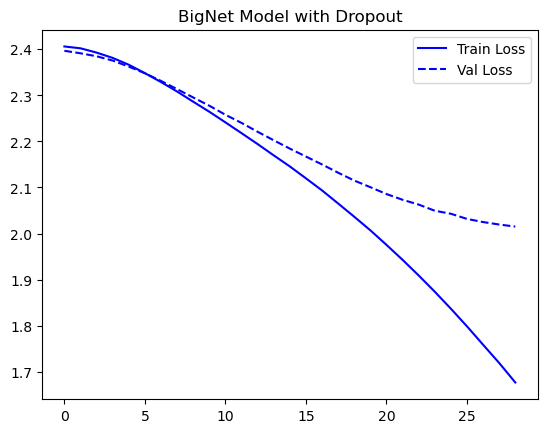

In [18]:
# Plot Train and Val losses
plt.plot(smooth(bignet_model_v3_metrics['train_loss'], 0.9), 'b')
plt.plot(smooth(bignet_model_v3_metrics['val_loss'], 0.9), 'b--')
plt.title('BigNet Model with Dropout')
plt.legend(['Train Loss', 'Val Loss'])

Η τεχνική Dropout φαίνεται να βοήθησε αρκετά καθότι πλέον το μοντέλο δείχνει να μπορεί να γενικεύει ωστόσο όχι σε ικανοποιητικό βαθμό.

## Προεκπαιδευμένο Νευρωνικό ∆ίκτυο (ResNet 50)

In [46]:
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn
# Initialize model with the best available weights
weights = ResNet50_Weights.IMAGENET1K_V2
resnet50_model = resnet50(weights=weights)
# Change Models Last FC Layer
# Το αφήνουμε για εσάς

num_classes = 11

# Αριθμός των χαρακτηριστικών εισόδου για το τελευταίο layer του ResNet50
num_features = resnet50_model.fc.in_features

# Ορισμός νέου πλήρως συνδεδεμένο layer
new_fc = nn.Linear(num_features, num_classes)

# Αντικατάσταση του τελευταίο πλήρως συνδεδεμένου layer του ResNet50 με το νέο
resnet50_model.fc = new_fc

In [20]:
# Ορίζουμε τον αλγόριθμο βελτιστοποίησης, το κριτήριο και τον βελτιστοποιητή
optimizer = optim.Adam(resnet50_model.parameters(), lr=0.0001, weight_decay=0.0005)
criterion = nn.CrossEntropyLoss()

# Εκπαιδεύουμε το μοντέλο
resnet50_model_metrics = train_model(resnet50_model, train_loader, val_loader, criterion, optimizer)

Epoch 1/30: 100%|██████████| 124/124 [00:31<00:00,  3.90it/s]


Train Loss: 1.0626, Train Accuracy: 0.7125
Validation Loss: 0.4428, Validation Accuracy: 0.8687


Epoch 2/30: 100%|██████████| 124/124 [00:31<00:00,  3.89it/s]


Train Loss: 0.2433, Train Accuracy: 0.9283
Validation Loss: 0.3790, Validation Accuracy: 0.8869


Epoch 3/30: 100%|██████████| 124/124 [00:31<00:00,  3.91it/s]


Train Loss: 0.0827, Train Accuracy: 0.9783
Validation Loss: 0.3851, Validation Accuracy: 0.8904


Epoch 4/30: 100%|██████████| 124/124 [00:31<00:00,  3.92it/s]


Train Loss: 0.0408, Train Accuracy: 0.9917
Validation Loss: 0.3975, Validation Accuracy: 0.8869


Epoch 5/30: 100%|██████████| 124/124 [00:31<00:00,  3.90it/s]


Train Loss: 0.0237, Train Accuracy: 0.9943
Validation Loss: 0.4031, Validation Accuracy: 0.8914


Epoch 6/30: 100%|██████████| 124/124 [00:31<00:00,  3.90it/s]


Train Loss: 0.0233, Train Accuracy: 0.9946
Validation Loss: 0.4269, Validation Accuracy: 0.8904


Epoch 7/30: 100%|██████████| 124/124 [00:31<00:00,  3.90it/s]


Train Loss: 0.0247, Train Accuracy: 0.9943
Validation Loss: 0.4679, Validation Accuracy: 0.8773
No improvement for 5 epochs. Early stopping...
Training completed.


<class 'torchvision.models.resnet.ResNet'>


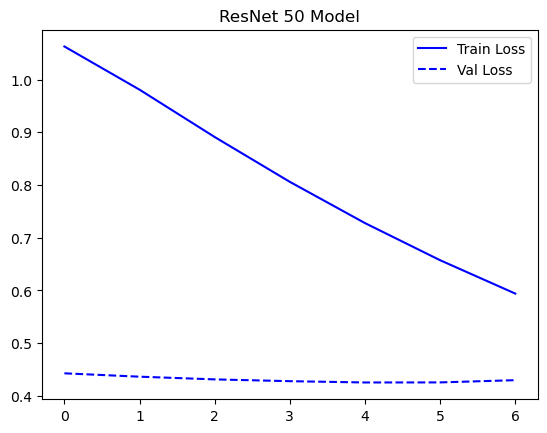

In [67]:
plt.plot(smooth(resnet50_model_metrics['train_loss'], 0.9), 'b')
plt.plot(smooth(resnet50_model_metrics['val_loss'], 0.9), 'b--')
plt.title('ResNet 50 Model')
plt.legend(['Train Loss', 'Val Loss'])

print(type(resnet50_model))

## Προεκπαιδευμένο Νευρωνικό ∆ίκτυο (ViT)

In [69]:
from torchvision.models import vit_b_16, ViT_B_16_Weights
import torch.nn as nn

# Number of classes for your specific task
num_classes = 11

# Initialize the ViT model with the best available weights
weights = ViT_B_16_Weights.IMAGENET1K_V1
vit_model = vit_b_16(weights=weights)

# Get the number of features in the last layer
num_features = vit_model.heads.head.in_features

# Define a new fully connected layer with the desired number of output classes
new_fc = nn.Linear(num_features, num_classes)

# Replace the original classification head with the new one
vit_model.heads.head = new_fc

In [54]:
# Ορίζουμε τον αλγόριθμο βελτιστοποίησης, το κριτήριο και τον βελτιστοποιητή
optimizer = optim.Adam(vit_model.parameters(), lr=0.0001, weight_decay=0.0005)
criterion = nn.CrossEntropyLoss()

# Εκπαιδεύουμε το μοντέλο
vit_model_metrics = train_model(vit_model, train_loader, val_loader, criterion, optimizer)

Epoch 1/30: 100%|██████████| 124/124 [01:14<00:00,  1.67it/s]


Train Loss: 0.6368, Train Accuracy: 0.7982
Validation Loss: 0.4600, Validation Accuracy: 0.8586


Epoch 2/30: 100%|██████████| 124/124 [01:14<00:00,  1.66it/s]


Train Loss: 0.1787, Train Accuracy: 0.9458
Validation Loss: 0.4132, Validation Accuracy: 0.8697


Epoch 3/30: 100%|██████████| 124/124 [01:14<00:00,  1.66it/s]


Train Loss: 0.1004, Train Accuracy: 0.9689
Validation Loss: 0.5793, Validation Accuracy: 0.8364


Epoch 4/30: 100%|██████████| 124/124 [01:14<00:00,  1.66it/s]


Train Loss: 0.0968, Train Accuracy: 0.9703
Validation Loss: 0.5738, Validation Accuracy: 0.8429


Epoch 5/30: 100%|██████████| 124/124 [01:14<00:00,  1.66it/s]


Train Loss: 0.0904, Train Accuracy: 0.9712
Validation Loss: 0.5931, Validation Accuracy: 0.8404


Epoch 6/30: 100%|██████████| 124/124 [01:14<00:00,  1.65it/s]


Train Loss: 0.0854, Train Accuracy: 0.9717
Validation Loss: 0.6133, Validation Accuracy: 0.8313


Epoch 7/30: 100%|██████████| 124/124 [01:14<00:00,  1.66it/s]


Train Loss: 0.0801, Train Accuracy: 0.9747
Validation Loss: 0.5357, Validation Accuracy: 0.8591
No improvement for 5 epochs. Early stopping...
Training completed.


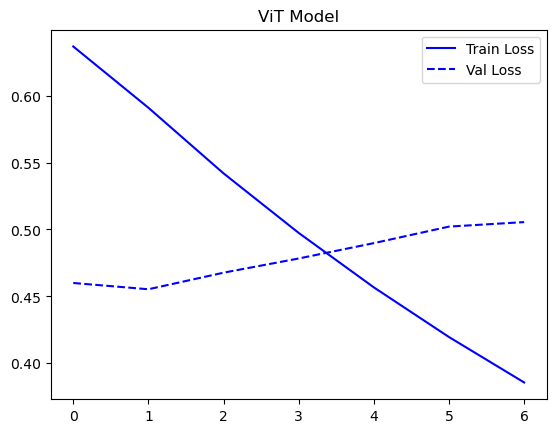

In [56]:
plt.plot(smooth(vit_model_metrics['train_loss'], 0.9), 'b')
plt.plot(smooth(vit_model_metrics['val_loss'], 0.9), 'b--')
plt.title('ViT Model')
plt.legend(['Train Loss', 'Val Loss'])

In [22]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def visualize_model(model, dataloaders, class_names, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0    
    fig, axes = plt.subplots(2, 3, figsize=(10, 6))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                row = images_so_far // 3
                col = images_so_far % 3
                ax = axes[row, col]
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                # ax.set_title(f'predicted: ')
                ax.imshow(inputs.cpu().data[j].permute(1, 2, 0))
                images_so_far += 1

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return

    model.train(mode=was_training)

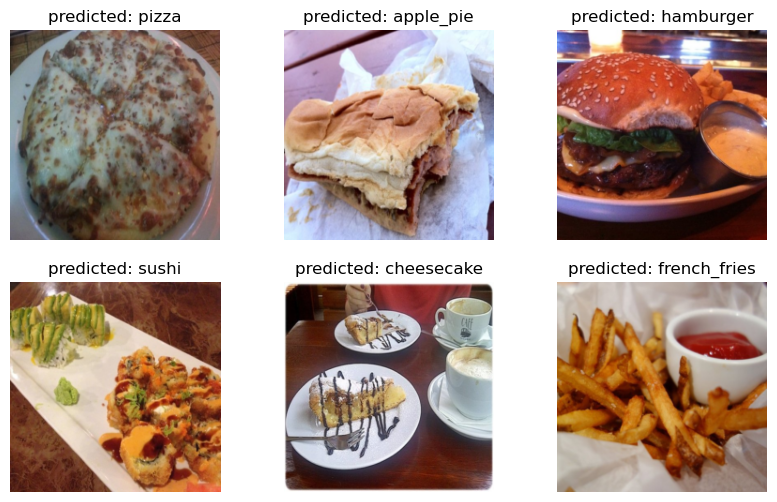

In [57]:
classes_names_list = list(classes.keys())

visualize_model(vit_model, val_loader, classes_names_list)

# BONUS

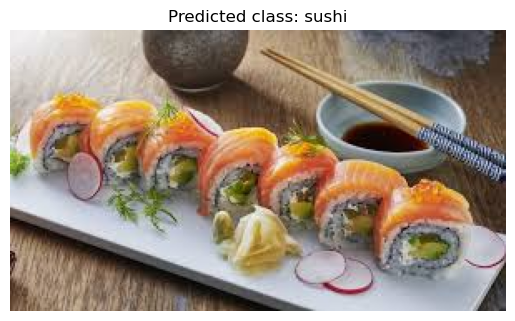

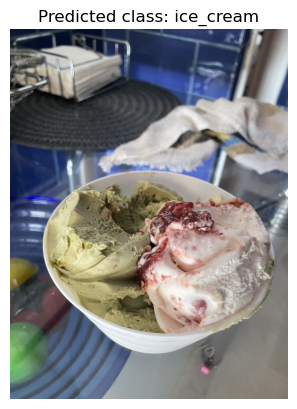

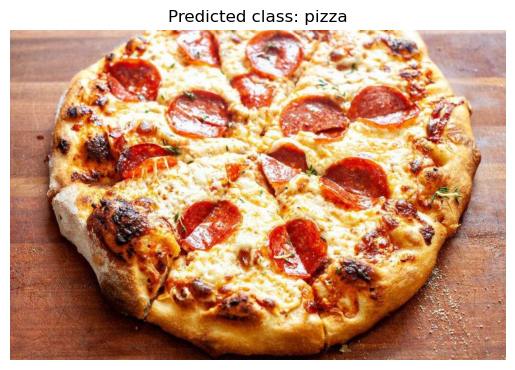

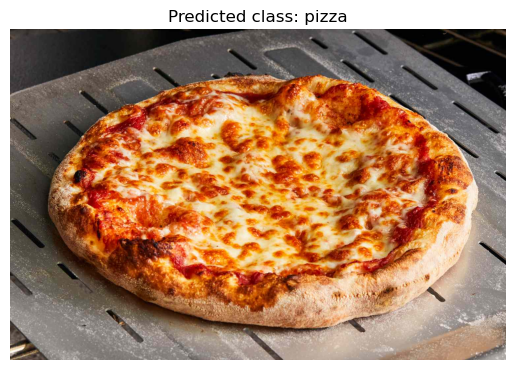

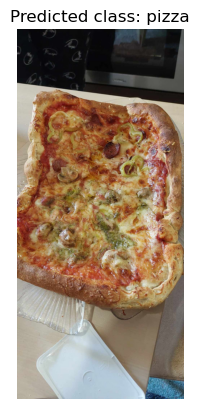

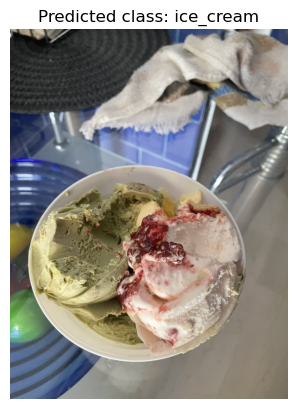

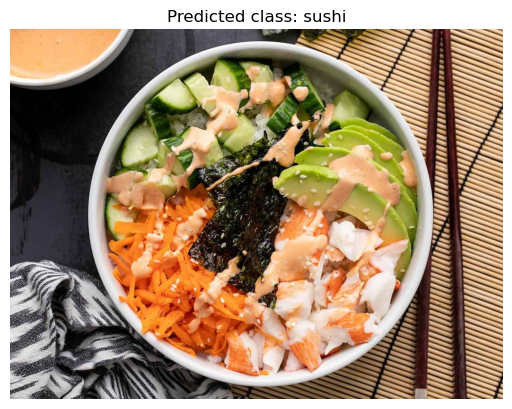

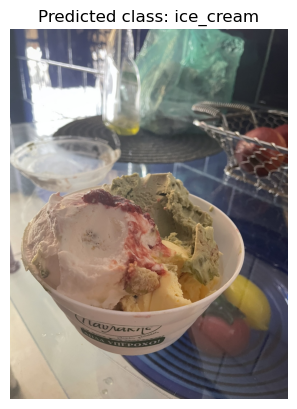

In [68]:
custom_images_path = "my_data"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = vit_model

# List all files in the directory
custom_images = os.listdir(custom_images_path)
custom_images = [entry for entry in custom_images if '.' in entry and not entry.startswith('.')]

# Loop through custom images and plot them individually
for custom_image in custom_images:
    image = Image.open(os.path.join(custom_images_path, custom_image))
    
    model.to(device)
    # Ensure the model is in evaluation mode before passing the image.
    model.eval()
    
    # Convert the custom image to tensor and move it to the appropriate device.
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    custom_image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Forward pass through the model
    with torch.no_grad():
        outputs = model(custom_image_tensor)
        _, predicted = torch.max(outputs, 1)

    # Get the predicted class label
    predicted_class = classes_names_list[predicted.item()]
    
    # Plot the image with the predicted class title
    plt.imshow(image)
    plt.title(f'Predicted class: {predicted_class}')
    plt.axis('off')
    plt.show()